In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_all.P_emaildomain.value_counts()

gmail.com           435803
yahoo.com           182784
hotmail.com          85649
anonymous.com        71062
aol.com              52337
comcast.net          14474
icloud.com           12316
outlook.com           9934
att.net               7647
msn.com               7480
sbcglobal.net         5767
live.com              5720
verizon.net           5011
ymail.com             4075
bellsouth.net         3437
yahoo.com.mx          2827
me.com                2713
cox.net               2657
optonline.net         1937
live.com.mx           1470
charter.net           1443
mail.com              1156
rocketmail.com        1105
gmail                  993
earthlink.net          979
outlook.es             863
mac.com                862
hotmail.fr             674
hotmail.es             627
frontier.com           594
roadrunner.com         583
juno.com               574
windstream.net         552
web.de                 518
aim.com                468
embarqmail.com         464
twc.com                439
f

In [3]:
%%time
#load data 
df_trans_train = pd.read_csv('./train_transaction.csv')
df_iden_train = pd.read_csv('./train_identity.csv')
df_trans_test = pd.read_csv('./test_transaction.csv')
df_iden_test = pd.read_csv('./test_identity.csv')


#merge train, test 
df_train = pd.merge(df_trans_train, df_iden_train, how = 'outer', on = ['TransactionID'])
df_test = pd.merge(df_trans_test, df_iden_test, how = 'outer', on = ['TransactionID'])
train_objs_num = len(df_train)
df_all = pd.concat(objs=[df_train, df_test], axis=0)
y = df_train.isFraud

del df_trans_train
del df_iden_train
del df_trans_test
del df_iden_test

#Feature Eng'ring
#log TransactionAmt
df_all['log_TransactionAmt'] = np.log(df_all.TransactionAmt)

# address combine
df_all['addr3'] = df_all['addr1'].astype(str) + '-' + df_all['addr2'].astype(str)

#Frd_factor
sums_D = df_all.D1.fillna(0)+df_all.D2.fillna(0)+df_all.D3.fillna(0)+df_all.D4.fillna(0)+df_all.D5.fillna(0)+df_all.D6.fillna(0)\
+df_all.D7.fillna(0)+df_all.D8.fillna(0)+df_all.D9.fillna(0)+df_all.D10.fillna(0)+df_all.D11.fillna(0)+df_all.D12.fillna(0)\
+df_all.D13.fillna(0)+df_all.D14.fillna(0)+df_all.D15.fillna(0)

sums_d = (df_all.dist1.fillna(np.nanmedian(df_all.dist1)) + df_all.dist2.fillna(np.nanmedian(df_all.dist2)))

#Frd_factor
df_all['timediff'] = (sums_D)
df_all['distance'] = (sums_d)
df_all['frd_factor'] = np.log(df_all.distance+2)*10 / np.log((df_all.timediff+500))

#Aggregation
for num_col in ['TransactionAmt', 'id_02', 'dist1','distance','frd_factor']:
    for cat_col in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1','addr2','addr3',
                    'ProductCD', 'P_emaildomain'
                   ]:
        df_all[f'{num_col}_to_mean_{cat_col}'] = df_all[num_col] / df_all.groupby([cat_col])[num_col].transform('mean')
        df_all[f'{num_col}_to_max_{cat_col}'] = df_all[num_col] / df_all.groupby([cat_col])[num_col].transform('max')
        df_all[f'{num_col}_to_min_{cat_col}'] = df_all[num_col] / df_all.groupby([cat_col])[num_col].transform('min')
        df_all[f'{num_col}_to_std_{cat_col}'] = df_all[num_col] / df_all.groupby([cat_col])[num_col].transform('std')

for cat_col in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'ProductCD', 'id_02', 'P_emaildomain']:
    df_all[f'{cat_col}_count'] = df_all.groupby([cat_col])['TransactionID'].transform('count')

#P_E_mail Domain
df_all["P_emaildomain"] = df_all["P_emaildomain"].str.split('.', expand = True)[[0]]

#R_E_mail Domain
df_all["R_emaildomain"] = df_all["R_emaildomain"].str.split('.', expand = True)[[0]]

#구매자 수신인 도메인 같은지 여부
df_all["domain_match"] = df_all["P_emaildomain"] == df_all["R_emaildomain"]

#널 여부를 피쳐로 사용
increasing_null_ratio_with_fraud_nums = ['addr1','addr2','D11','V7','V8','V9','V10','V11','V1','V6','V4','V2','V3','V5']
increasing_null_ratio_with_fraud_cats = ['M6','M3','M2','M1']

for null in increasing_null_ratio_with_fraud_nums:
    df_all['isnull_'+null] = df_all[null].isnull()

for null in increasing_null_ratio_with_fraud_cats:
    df_all['isnull_'+null] = df_all[null].isnull()

#널 개수를 피쳐로 사용
df_all['num_of_nulls'] = df_all.isna().sum(axis=1)

#Unique value 많은 것들 묶어주기(id30)
df_all.loc[df_all['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
df_all.loc[df_all['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_all.loc[df_all['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
df_all.loc[df_all['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_all.loc[df_all['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'


#DeviceInfo
df_all.loc[df_all['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
df_all.loc[df_all['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
df_all.loc[df_all['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
df_all.loc[df_all['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
df_all.loc[df_all['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
df_all.loc[df_all['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
df_all.loc[df_all['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
df_all.loc[df_all['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
df_all.loc[df_all['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
df_all.loc[df_all['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
df_all.loc[df_all['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
df_all.loc[df_all['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
df_all.loc[df_all['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
df_all.loc[df_all['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
df_all.loc[df_all['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
df_all.loc[df_all['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
df_all.loc[df_all['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'
df_all.loc[df_all.DeviceInfo.isin(df_all.DeviceInfo.value_counts()[df_all.DeviceInfo.value_counts() < 200].index), 'DeviceInfo'] = "Others"

#버전 제거
df_all['id_31'] = df_all['id_31'].str.replace('\d+', '')
df_all['id_31'] = df_all['id_31'].str.replace('.', '')


# 해상도 --> 곱으로 화면크기로 변환 --> id_33 삭제
df_all['resolution'] = df_all.id_33.fillna(df_all.id_33.mode()[0]).apply(lambda x : eval(x.replace('x','*')))
df_all = df_all.drop(columns='id_33')

#cat/num split
features = pd.DataFrame({'feature' : df_all.columns, 'dtype' : df_all.dtypes}).reset_index(drop = 'True')
cat_features = features[(features.dtype != 'int64') & (features.dtype != 'float64')]

num_index = [i for i in features.index if i not in cat_features.index]
num_features = features.iloc[num_index]
num_features = num_features[num_features.feature != 'isFraud'].reset_index(drop = 'True')

cat = df_all[cat_features.feature]
nums = df_all[num_features.feature]

train_objs_num = len(df_train)
cats = pd.get_dummies(cat)

#Memory Saving
del df_test

Wall time: 48min 2s


In [13]:
nums = reduce_mem_usage(cats)

Memory usage of dataframe is 914.55 MB --> 1820.74 MB (Decreased by -99.1%)


In [4]:
#Define X,y
X = pd.concat([nums,cats],axis = 1)
X_train = X[:train_objs_num].drop(columns = 'TransactionID')
X_test =  X[train_objs_num:].drop(columns = 'TransactionID')
y = df_train.isFraud
del X

MemoryError: 

In [11]:
import sys
sys.getsizeof(nums)

5617822744

In [0]:
 X_train.shape,X_test.shape,y.shape

((590540, 1067), (506691, 1067), (590540,))

In [10]:
for col in cat.columns:
  print('col : {}, # of uniq. value : {}'.format(col,len(cat[col].value_counts())))

col : DeviceInfo, # of uniq. value : 14
col : DeviceType, # of uniq. value : 2
col : M1, # of uniq. value : 2
col : M2, # of uniq. value : 2
col : M3, # of uniq. value : 2
col : M4, # of uniq. value : 3
col : M5, # of uniq. value : 2
col : M6, # of uniq. value : 2
col : M7, # of uniq. value : 2
col : M8, # of uniq. value : 2
col : M9, # of uniq. value : 2
col : P_emaildomain, # of uniq. value : 45
col : ProductCD, # of uniq. value : 5
col : R_emaildomain, # of uniq. value : 45
col : card4, # of uniq. value : 4
col : card6, # of uniq. value : 4
col : id_12, # of uniq. value : 2
col : id_15, # of uniq. value : 3
col : id_16, # of uniq. value : 2
col : id_23, # of uniq. value : 3
col : id_27, # of uniq. value : 2
col : id_28, # of uniq. value : 2
col : id_29, # of uniq. value : 2
col : id_30, # of uniq. value : 7
col : id_31, # of uniq. value : 66
col : id_33, # of uniq. value : 461
col : id_34, # of uniq. value : 4
col : id_35, # of uniq. value : 2
col : id_36, # of uniq. value : 2
col :

In [0]:
import pickle
with open('/content/gdrive/My Drive/DL/FRD/X_train_w_null.pkl', 'wb') as f:
  pickle.dump(X_train,f)
with open('/content/gdrive/My Drive/DL/FRD/X_test_w_null.pkl', 'wb') as f:
  pickle.dump(X_test,f)
with open('/content/gdrive/My Drive/DL/FRD/y.pkl', 'wb') as f:
  pickle.dump(y,f)

In [0]:
df_trans_train = pd.read_csv('/content/gdrive/My Drive/DL/FRD/train_transaction.csv')
df_iden_train = pd.read_csv('/content/gdrive/My Drive/DL/FRD/train_identity.csv')

df_trans_test = pd.read_csv('/content/gdrive/My Drive/DL/FRD/test_transaction.csv')
df_iden_test = pd.read_csv('/content/gdrive/My Drive/DL/FRD/test_identity.csv')

In [0]:
df_trans_train.shape, df_iden_train.shape, df_trans_test.shape, df_iden_test.shape

((590540, 394), (144233, 41), (506691, 393), (141907, 41))

In [0]:
df_train = pd.merge(df_trans_train, df_iden_train, how = 'outer', on = ['TransactionID'])
df_test = pd.merge(df_trans_test, df_iden_test, how = 'outer', on = ['TransactionID'])
y = df_train.isFraud
#df= df.drop(columns = 'isFraud')

In [0]:
df_train.shape, df_test.shape

((590540, 443), (506691, 433))

# Transaction Table #
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features:
    - ProductCD
    - card1
    - card2
    - card3
    - card4
    - card5
    - card6
    - addr1, addr2 : addr1 as billing region / addr2 as billing country
    - Pemaildomain Remaildomain
    - M1 - M9

# Identity Table 
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

- Categorical Features:
    -  DeviceType
    - DeviceInfo
    - id12 - id38

# Null Handling
- NULL 개수가 매우많다 : Thresholding 필요
- NULL 개수가 정확히 같은 것들은 묶어서 Feature Engineering 필요

In [0]:
features = pd.DataFrame({'feature' : df_train.columns, 'dtype' : df_train.dtypes}).reset_index(drop = 'True')
cat_features = features[(features.dtype != 'int64') & (features.dtype != 'float64')]

num_index = [i for i in features.index if i not in cat_features.index]
num_features = features.iloc[num_index]
num_features = num_features[num_features.feature != 'isFraud'].reset_index(drop = 'True')

In [0]:
null_pct = []
for i, col in enumerate(num_features.feature):
    nulls = 100 * df_train[col].isnull().sum() / df_train.shape[0]
    null_pct.append(nulls)
num_features['null_ratio'] = null_pct

In [0]:
null_pct = []
for i, col in enumerate(cat_features.feature):
    nulls = 100 * df_train[col].isnull().sum() / df_train.shape[0]
    null_pct.append(nulls)
cat_features['null_ratio'] = null_pct

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [0]:
def percent_na(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing},index=None)
    #missing_value_df.sort_values('percent_missing', inplace=True)
    missing_value_df=missing_value_df.reset_index().drop('index',axis=1)
    return missing_value_df
df_na_train = percent_na(df_train)
df_na_test = percent_na(df_test)

In [0]:
df_na_train.sort_values(by = 'percent_missing',ascending = [False])

,column_name,percent_missing
417,id_24,99.196159
418,id_25,99.130965
400,id_07,99.127070
401,id_08,99.127070
414,id_21,99.126393
419,id_26,99.125715
420,id_27,99.124699
416,id_23,99.124699
415,id_22,99.124699
14,dist2,93.628374


In [0]:
df_na_test.sort_values(by = 'percent_missing', ascending = [False])

,column_name,percent_missing
416,id_24,99.064519
417,id_25,99.005508
418,id_26,99.003929
413,id_21,99.001561
400,id_08,99.001561
399,id_07,99.001561
419,id_27,99.000969
415,id_23,99.000969
414,id_22,99.000969
13,dist2,92.809030


In [0]:
col_na_group= df_na_train.groupby('percent_missing')['column_name'].unique().reset_index()
num_columns=[]
for i in range(len(col_na_group)):
    num_columns.append(len(col_na_group.column_name[i]))
col_na_group['num_columns']=num_columns
col_na_group = col_na_group.loc[(col_na_group['num_columns']>1) & (col_na_group['percent_missing']>0),].sort_values(by='percent_missing',ascending=False).reset_index()
col_na_group

,index,percent_missing,column_name,num_columns
0,67,99.127070,"[id_07, id_08]",2
1,64,99.124699,"[id_22, id_23, id_27]",3
2,57,88.768923,"[id_03, id_04]",2
3,54,87.312290,"[D8, D9, id_09, id_10]",4
4,49,86.123717,"[V138, V139, V140, V141, V142, V146, V147, V14...",18
5,48,86.122701,"[V143, V144, V145, V150, V151, V152, V159, V16...",11
6,47,86.054967,"[V322, V323, V324, V325, V326, V327, V328, V32...",18
7,43,77.913435,"[V217, V218, V219, V223, V224, V225, V226, V22...",46
8,42,76.823755,"[id_05, id_06]",2
9,37,76.355370,"[V167, V168, V172, V173, V176, V177, V178, V17...",31


# 널 개수와 Y 와의 상관관계

In [0]:
df_train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
                   ...  
id_11             449562
id_12             446307
id_13             463220
id_14             510496
id_15             449555
id_16             461200
id_17             451171
id_18             545427
id_19             451222


In [0]:
def null_slayer(data, thresh):
    numeric_remains = num_features[num_features.null_ratio <= thresh].feature.tolist()
    cat_remains = cat_features[cat_features.null_ratio <= thresh].feature.tolist()
    remains = numeric_remains + cat_remains
    df = data[remains]
    return df

In [0]:
df_normal = df_train[df_train.isFraud == 0].drop(columns = 'isFraud')
df_fraud = df_train[df_train.isFraud == 1].drop(columns = 'isFraud')
normal_nulls = (100 * df_normal.isnull().sum()) / len(df_normal)
fraud_nulls = (100 * df_fraud.isnull().sum()) / len(df_fraud)

In [0]:
normal_null_ratio = pd.DataFrame({'feature' : normal_nulls.index, 'null_ratio' : normal_nulls,
                                 'isFraud' : 0}).reset_index(drop = 'True')
fraud_null_ratio = pd.DataFrame({'feature' : fraud_nulls.index, 'null_ratio' : fraud_nulls, 'isFraud' : 1}).reset_index(drop = 'True')

In [0]:
null_ratios = pd.concat([normal_null_ratio,fraud_null_ratio])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

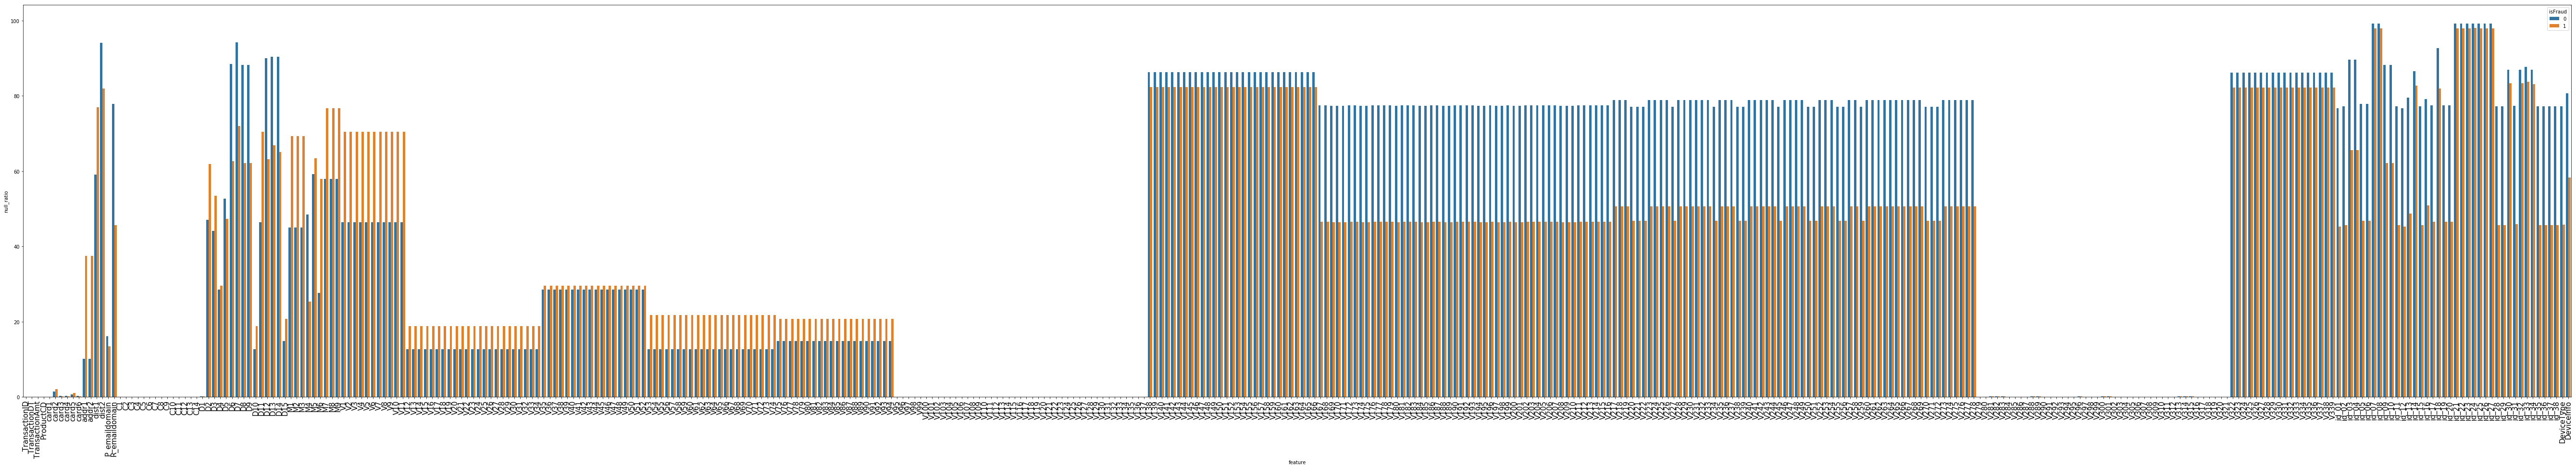

In [0]:
plt.figure(figsize = (95,15))
sns.barplot(x = null_ratios.feature, y  = null_ratios.null_ratio, hue = null_ratios.isFraud)
plt.xticks(rotation = 90,size = 15)

# Fraud 에서 NULL 값이 증가하는 것들

In [0]:
null_info = pd.DataFrame({'Feature' : fraud_nulls.index, 'normal_null_ratio' : normal_nulls, 'fraud_null_ratio' : fraud_nulls, 'diff' : fraud_nulls - normal_nulls}).reset_index(drop = 'True')
null_info[null_info['diff'] > 0].sort_values(by = 'diff', ascending = [False])

,Feature,normal_null_ratio,fraud_null_ratio,diff
50,M6,27.618065,57.934472,30.316407
10,addr1,10.171493,37.463098,27.291605
11,addr2,10.171493,37.463098,27.291605
47,M3,45.058671,69.307458,24.248787
46,M2,45.058671,69.307458,24.248787
45,M1,45.058671,69.307458,24.248787
59,V6,46.453884,70.449596,23.995712
57,V4,46.453884,70.449596,23.995712
55,V2,46.453884,70.449596,23.995712
56,V3,46.453884,70.449596,23.995712


# Cat EDA

In [0]:
cats_train = df_train[cat_features.feature]
nums_train = df_train[num_features.feature]

cats_test = df_test[cat_features.feature]
nums_test = df_test[num_features.feature]

In [0]:
uniques_train = pd.DataFrame(columns = ['feature','unique_nums'])
for feat in cat_features.feature:
    unique = len(cats_train[feat].unique())
    uniques_train = uniques_train.append({'feature' : feat , 'unique_nums' : unique} , ignore_index=True)
    
uniques_test = pd.DataFrame(columns = ['feature','unique_nums'])
for feat in cat_features.feature:
    unique = len(cats_test[feat].unique())
    uniques_test = uniques_test.append({'feature' : feat , 'unique_nums' : unique} , ignore_index=True)

# ID 30, 31,33,Device Info 너무 많다

In [0]:
uniques_train

,feature,unique_nums
0,ProductCD,5
1,card4,5
2,card6,5
3,P_emaildomain,60
4,R_emaildomain,61
5,M1,3
6,M2,3
7,M3,3
8,M4,4
9,M5,3


In [0]:
uniques_test

,feature,unique_nums
0,ProductCD,5
1,card4,5
2,card6,4
3,P_emaildomain,61
4,R_emaildomain,61
5,M1,3
6,M2,3
7,M3,3
8,M4,4
9,M5,3


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


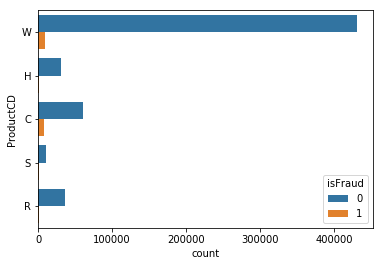

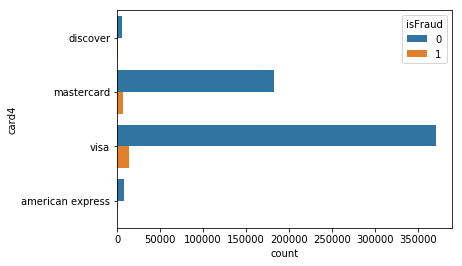

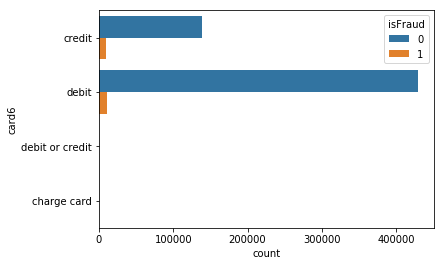

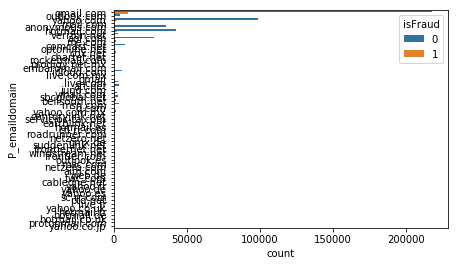

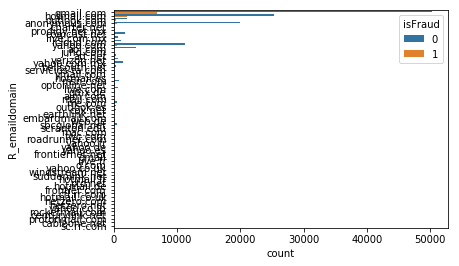

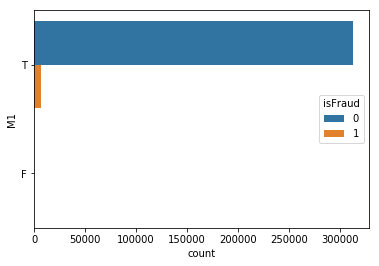

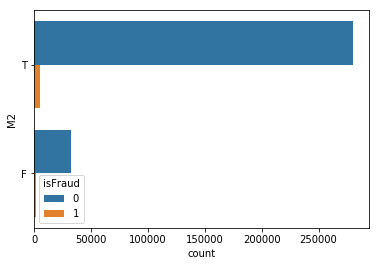

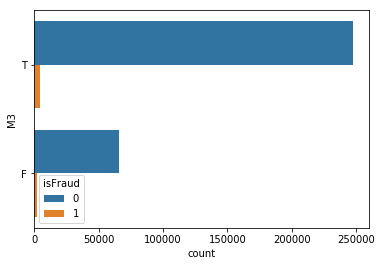

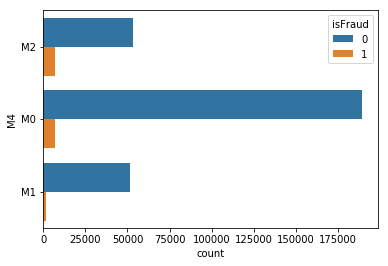

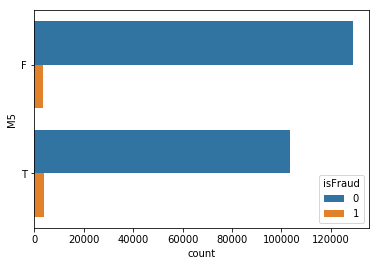

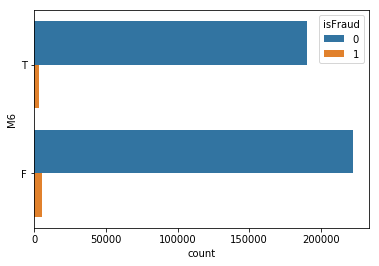

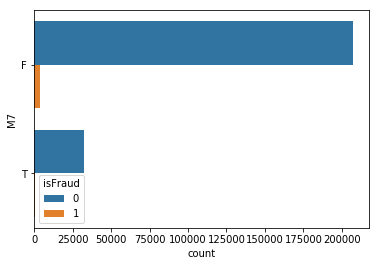

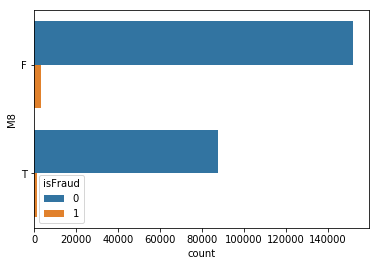

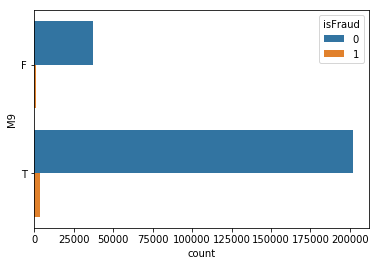

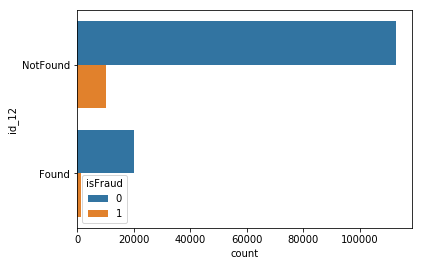

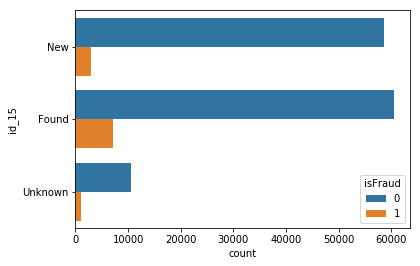

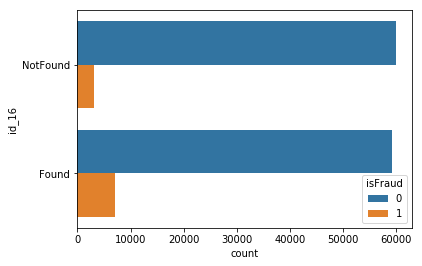

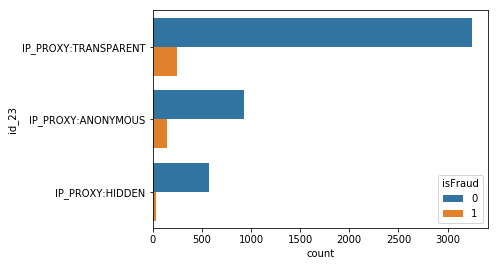

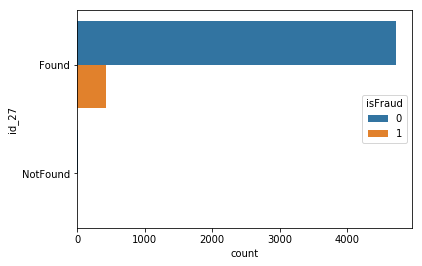

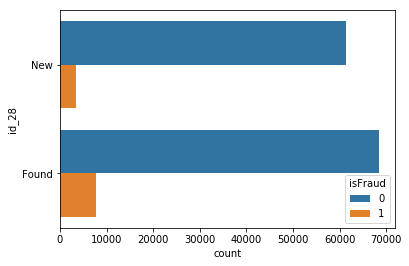

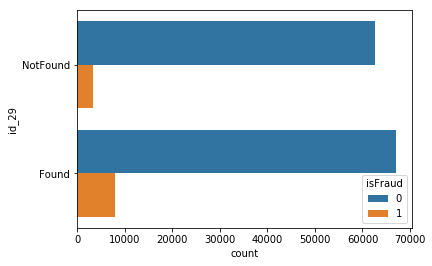

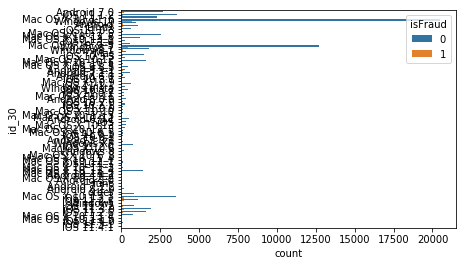

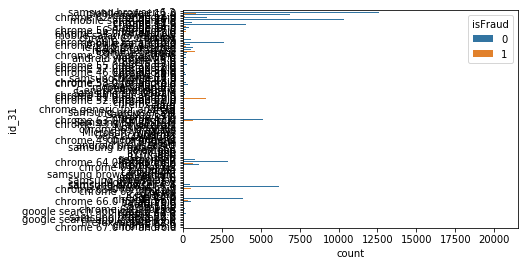

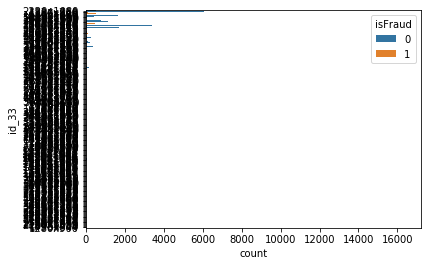

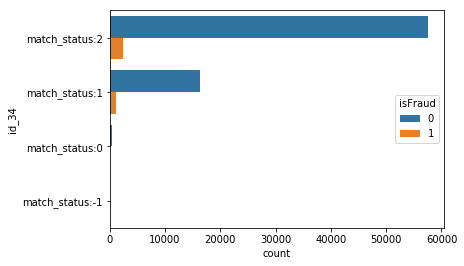

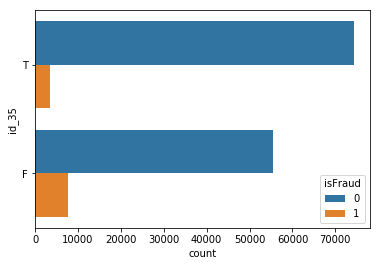

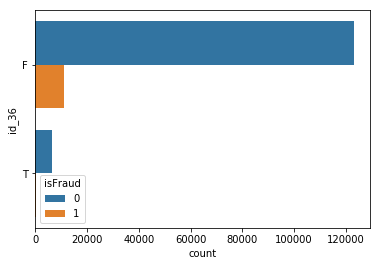

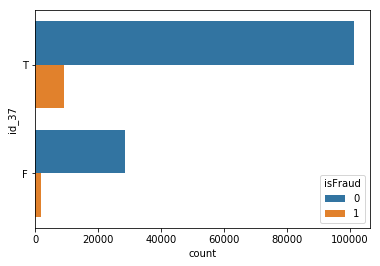

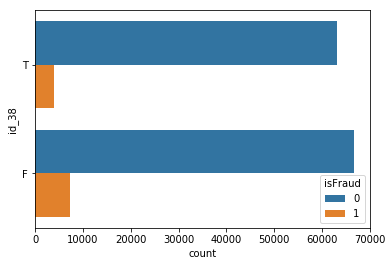

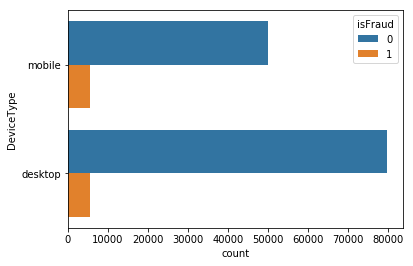

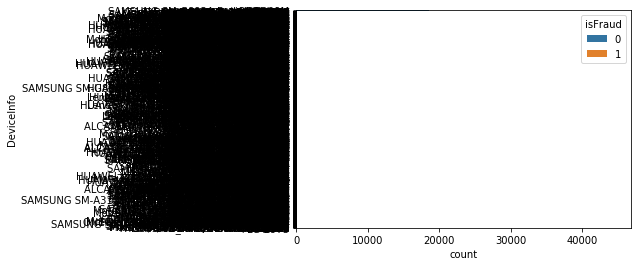

In [0]:
for feat in cat_features.feature:
    plt.figure()
    sns.countplot(y = df_train[feat],hue = df_train['isFraud'])

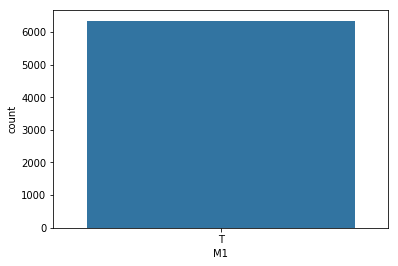

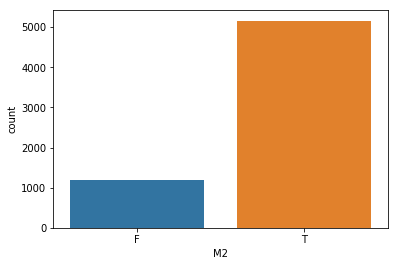

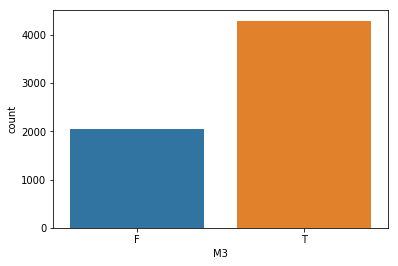

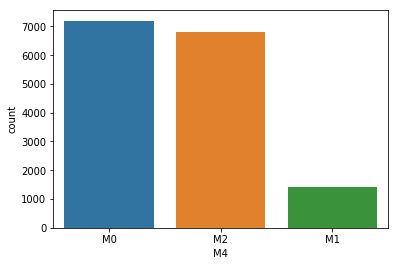

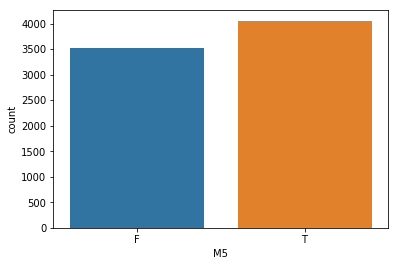

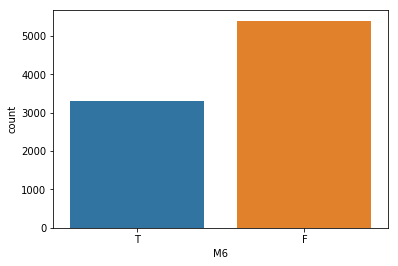

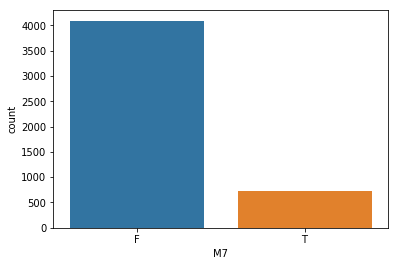

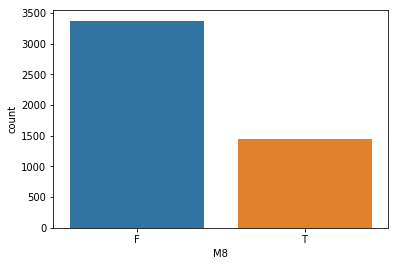

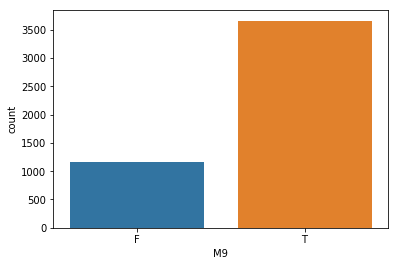

In [0]:
Ms = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
for M in Ms:
    plt.figure()
    sns.countplot(df_fraud[M])

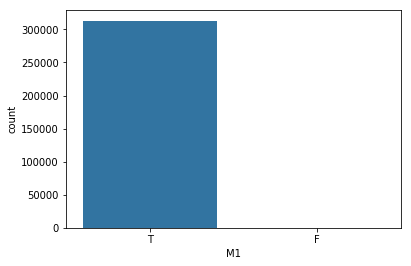

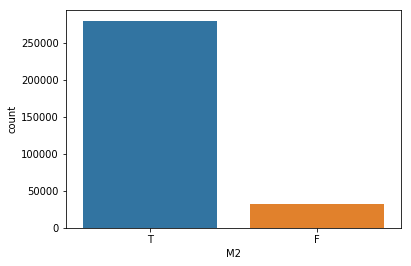

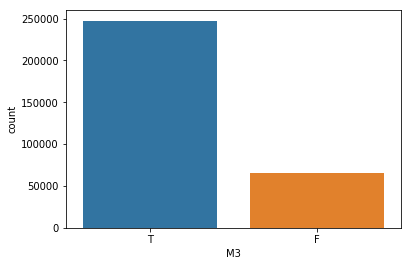

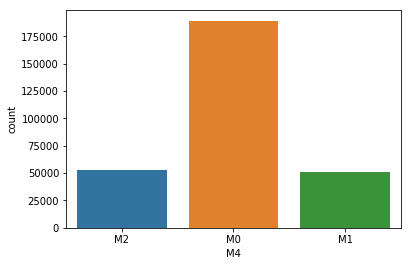

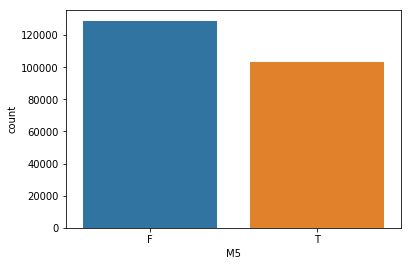

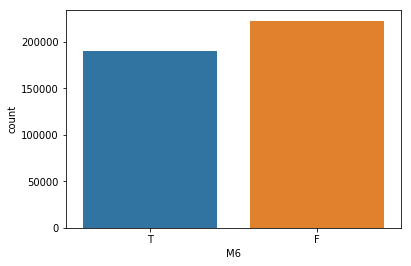

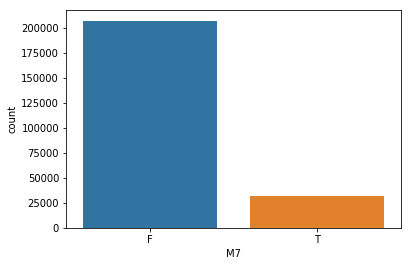

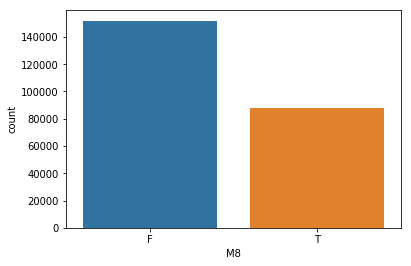

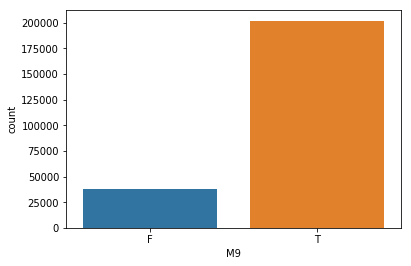

In [0]:
Ms = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
for M in Ms:
    plt.figure()
    sns.countplot(df_normal[M])

# Numeric EDA

# distance

In [0]:
df_train[['dist1','dist2']].groupby(df_train["isFraud"]).median()

,dist1,dist2
isFraud,,
0,8.0,36.0
1,10.0,49.0


In [0]:
df_train[['dist1','dist2']].groupby(df_train["isFraud"]).mean()

,dist1,dist2
isFraud,,
0,117.360098,235.199758
1,174.588854,201.472259


In [0]:
df_train[df_train.isFraud == 0].dist1.isnull().sum() / len(df_train[df_train.isFraud == 0]),df_train[df_train.isFraud == 1].dist1.isnull().sum() / len(df_train[df_train.isFraud == 1])

(0.5902378934401634, 0.7698785268354063)

In [0]:
df_train[df_train.isFraud == 0].dist2.isnull().sum() / len(df_train[df_train.isFraud == 0]),df_train[df_train.isFraud == 1].dist2.isnull().sum() / len(df_train[df_train.isFraud == 1])

(0.9405204982829628, 0.819435706334995)

In [0]:
np.std(df_train[df_train.isFraud == 0].dist1), np.std(df_train[df_train.isFraud == 1].dist1)

(370.64108567781216, 424.1877015459727)

In [0]:
np.std(df_train[df_train.isFraud == 0].dist2), np.std(df_train[df_train.isFraud == 1].dist2)

(536.7905737679166, 451.5290535106868)

# Feature Engineering

# 거리 / 시간 : 짧은 시간 안에 멀리 떨어진 곳에서 거래 = Fraud

In [0]:
Ds = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']
distances = ['dist1','dist2']

In [0]:
timediff = np.zeros((len(df_train,)))
for D in Ds:
    timediff += df_train[D]

In [0]:
for i, D in enumerate(Ds):
    sums_D = 0
    sums_D += df_train[Ds[i]].fillna(0)

In [0]:
sums_D = df_train.D1.fillna(0)+df_train.D2.fillna(0)+df_train.D3.fillna(0)+df_train.D4.fillna(0)+df_train.D5.fillna(0)+df_train.D6.fillna(0)\
+df_train.D7.fillna(0)+df_train.D8.fillna(0)+df_train.D9.fillna(0)+df_train.D10.fillna(0)+df_train.D11.fillna(0)+df_train.D12.fillna(0)\
+df_train.D13.fillna(0)+df_train.D14.fillna(0)+df_train.D15.fillna(0)

In [0]:
sums_d = (df_train.dist1.fillna(np.nanmedian(df_train.dist1)) + df_train.dist2.fillna(np.nanmedian(df_train.dist2)))

In [0]:
sums_D_test = df_test.D1.fillna(0)+df_test.D2.fillna(0)+df_test.D3.fillna(0)+df_test.D4.fillna(0)+df_test.D5.fillna(0)+df_test.D6.fillna(0)\
+df_test.D7.fillna(0)+df_test.D8.fillna(0)+df_test.D9.fillna(0)+df_test.D10.fillna(0)+df_test.D11.fillna(0)+df_test.D12.fillna(0)\
+df_test.D13.fillna(0)+df_test.D14.fillna(0)+df_test.D15.fillna(0)

In [0]:
sums_d_test = (df_test.dist1.fillna(np.nanmedian(df_test.dist1)) + df_test.dist2.fillna(np.nanmedian(df_test.dist2)))

In [0]:
df_train['timediff'] = (sums_D)
df_train['distance'] = (sums_d)
df_train['frd_factor'] = np.log(df_train.distance+2)*10 / np.log((df_train.timediff+500))

df_test['timediff'] = (sums_D_test)
df_test['distance'] = (sums_d_test)
df_test['frd_factor'] = np.log(df_test.distance+2)*10 / np.log((df_test.timediff+500))

nums_train['timediff'] = (sums_D)
nums_train['distance'] = (sums_d)
nums_train['frd_factor'] = np.log(nums_train.distance+2)*10 / np.log((nums_train.timediff+500))

nums_test['timediff'] = (sums_D_test)
nums_test['distance'] = (sums_d_test)
nums_test['frd_factor'] = np.log(nums_test.distance+2)*10 / np.log((nums_test.timediff+500))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [0]:
df_train[['distance','frd_factor','timediff','TransactionAmt']].groupby(df_train["isFraud"]).mean()

,distance,frd_factor,timediff,TransactionAmt
isFraud,,,,
0,101.600447,5.916842,699.731771,134.511665
1,113.033490,6.173191,338.706000,149.244779


In [0]:
df_train[['distance','frd_factor','timediff','isFraud']].corr(method = 'pearson')

,distance,frd_factor,timediff,isFraud
distance,1.000000,0.738160,0.020449,0.007536
frd_factor,0.738160,1.000000,-0.400302,0.039699
timediff,0.020449,-0.400302,1.000000,-0.076226
isFraud,0.007536,0.039699,-0.076226,1.000000


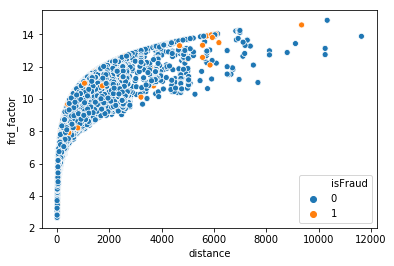

In [0]:
sns.scatterplot(df_train.distance, df_train.frd_factor, hue = df_train['isFraud'])

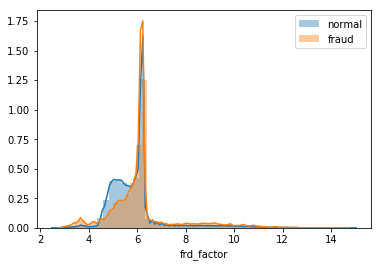

In [0]:
sns.distplot(df_train[df_train.isFraud == 0].frd_factor, label = 'normal')
sns.distplot(df_train[df_train.isFraud == 1].frd_factor, label = 'fraud')
plt.legend()

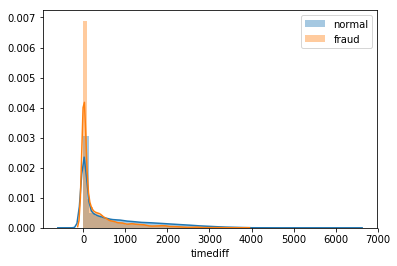

In [0]:
sns.distplot(df_train[df_train.isFraud == 0].timediff, label = 'normal')
sns.distplot(df_train[df_train.isFraud == 1].timediff, label = 'fraud')
plt.legend()

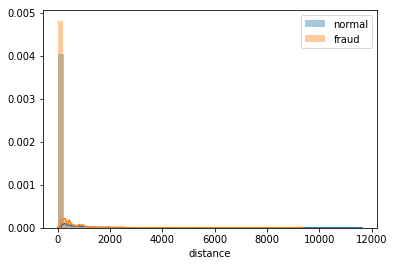

In [0]:
sns.distplot(df_train[df_train.isFraud == 0].distance, label = 'normal')
sns.distplot(df_train[df_train.isFraud == 1].distance, label = 'fraud')
plt.legend()

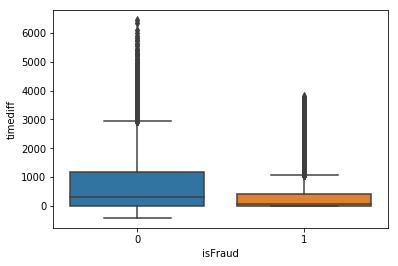

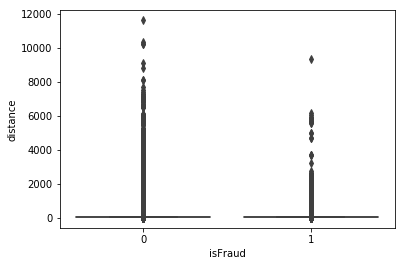

In [0]:
plt.figure()
sns.boxplot(df_train['isFraud'], df_train.timediff)
plt.figure()
sns.boxplot(df_train['isFraud'], df_train.distance)

# 널 개수를 피쳐로 사용

In [0]:
null_top5 = ['M6','addr1','addr2','M3','M2']
for null in null_top5:
    df_train['isnull_'+null] = df_train[null].isnull()
    cats_train['isnull_'+null] = df_train[null].isnull()
    cats_test['isnull_'+null] = df_test[null].isnull()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Unique 개수 많은 것들 묶어주기 (id30 ,31,33, Device Info)

In [0]:
#collapse os types - id_30
cats_train.loc[cats_train['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
cats_train.loc[cats_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
cats_train.loc[cats_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
cats_train.loc[cats_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
cats_train.loc[cats_train['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'

cats_test.loc[cats_test['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
cats_test.loc[cats_test['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
cats_test.loc[cats_test['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
cats_test.loc[cats_test['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
cats_test.loc[cats_test['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
#cats_train['DeviceInfo'] = cats_train['DeviceInfo'].str.split('/', expand=True)[0]

cats_train.loc[cats_train['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
cats_train.loc[cats_train['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
cats_train.loc[cats_train['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
cats_train.loc[cats_train['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
cats_train.loc[cats_train['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
cats_train.loc[cats_train['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
cats_train.loc[cats_train['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
cats_train.loc[cats_train['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
cats_train.loc[cats_train['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
cats_train.loc[cats_train['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
cats_train.loc[cats_train['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
cats_train.loc[cats_train['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
cats_train.loc[cats_train['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
cats_train.loc[cats_train['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
cats_train.loc[cats_train['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
cats_train.loc[cats_train['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
cats_train.loc[cats_train['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'

cats_train.loc[cats_train.DeviceInfo.isin(cats_train.DeviceInfo.value_counts()[cats_train.DeviceInfo.value_counts() < 200].index), 'DeviceInfo'] = "Others"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
#cats_test['DeviceInfo'] = cats_test['DeviceInfo'].str.split('/', expand=True)[0]

cats_test.loc[cats_test['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
cats_test.loc[cats_test['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
cats_test.loc[cats_test['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
cats_test.loc[cats_test['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
cats_test.loc[cats_test['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
cats_test.loc[cats_test['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
cats_test.loc[cats_test['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
cats_test.loc[cats_test['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
cats_test.loc[cats_test['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
cats_test.loc[cats_test['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
cats_test.loc[cats_test['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
cats_test.loc[cats_test['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
cats_test.loc[cats_test['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
cats_test.loc[cats_test['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
cats_test.loc[cats_test['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
cats_test.loc[cats_test['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
cats_test.loc[cats_test['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'

cats_test.loc[cats_test.DeviceInfo.isin(cats_test.DeviceInfo.value_counts()[cats_test.DeviceInfo.value_counts() < 200].index), 'DeviceInfo'] = "Others"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# 버전 제거

In [0]:
cats_train['id_31'] = cats_train['id_31'].str.replace('\d+', '')
cats_train['id_31'] = cats_train['id_31'].str.replace('.', '')

cats_test['id_31'] = cats_test['id_31'].str.replace('\d+', '')
cats_test['id_31'] = cats_test['id_31'].str.replace('.', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [0]:
# 해상도 --> 곱으로 화면크기로 변환 --> numeric 으로 보냄
df_train['resolution'] = cats_train.id_33[~cats_train.id_33.isnull()].apply(lambda x : eval(x.replace('x','*')))
nums_train['resolution'] = cats_train.id_33[~cats_train.id_33.isnull()].apply(lambda x : eval(x.replace('x','*')))
cats_train = cats_train.drop(columns = 'id_33')

nums_test['resolution'] = cats_test.id_33[~cats_test.id_33.isnull()].apply(lambda x : eval(x.replace('x','*')))
cats_test = cats_test.drop(columns = 'id_33')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# FILLNA

In [0]:
%%time
for col in cats_train.columns:
    cats_train[col] = cats_train[col].fillna(cats_train[col].mode()[0])
for col in nums_train.columns:
    nums_train[col] = nums_train[col].fillna(nums_train[col].mode()[0])
    
for col in cats_test.columns:
    cats_test[col] = cats_test[col].fillna(cats_test[col].mode()[0])
for col in nums_test.columns:
    nums_test[col] = nums_test[col].fillna(nums_test[col].mode()[0])

# Define Train data

In [0]:
from sklearn import preprocessing
for f in cats_train.columns:
  cats_train

In [0]:
cats_test.TransactionID

AttributeError: ignored

In [0]:
from sklearn import preprocessing
for f in cats_train.columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(cats_train[f])
    cats_train[f] = lbl.transform(cats_train[f])
    cats_test[f] = lbl.transform(cats_test[f])

TypeError: ignored

In [0]:
X_train = pd.concat([nums_train,cats_train],axis = 1)
X_test = pd.concat([nums_test,cats_test],axis = 1)
y = df_train.isFraud

In [0]:
X_train.shape, X_test.shape

In [0]:
import pickle
# save
with open('/content/gdrive/My Drive/DL/FRD/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('/content/gdrive/My Drive/DL/FRD/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('/content/gdrive/My Drive/DL/FRD/y.pkl', 'wb') as f:
    pickle.dump(y, f)
with open('/content/gdrive/My Drive/DL/FRD/df_train.pkl', 'wb') as f:
    pickle.dump(df_train, f)
with open('/content/gdrive/My Drive/DL/FRD/df_test.pkl', 'wb') as f:
    pickle.dump(df_test, f)

In [0]:
# load
import pickle
with open('/content/gdrive/My Drive/DL/FRD/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/gdrive/My Drive/DL/FRD/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('/content/gdrive/My Drive/DL/FRD/y.pkl', 'rb') as f:
    y = pickle.load(f)
# with open('/content/gdrive/My Drive/DL/FRD/df_train.pkl', 'rb') as f:
#     pickle.load(f)
# with open('/content/gdrive/My Drive/DL/FRD/df_test.pkl', 'rb') as f:
#     pickle.load(f)


# Feature Importance

In [0]:
%%time
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0).fit(X_train, y)

CPU times: user 2min 3s, sys: 680 ms, total: 2min 4s
Wall time: 2min 4s


In [0]:
importances = model1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
%%time
from xgboost import XGBClassifier
model_xgb = XGBClassifier(max_depth=5,learning_rate=1e-04,n_estimators=1000,verbosity=2)
model_xgb.fit(X_train,y)

[04:42:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:42:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:43:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[04:43:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nod

In [0]:
#save model
pickle.dump(model_xgb, open("/content/gdrive/My Drive/DL/FRD/model_xgb.pickle.dat", "wb"))

In [0]:
# load model from file
model_xgb = pickle.load(open("/content/gdrive/My Drive/DL/FRD/model_xgb.pickle.dat", "rb"))

In [0]:
model_xgb.save('/content/gdrive/My Drive/DL/FRD/model_xgb.h5')

AttributeError: ignored

In [0]:
import pickle
with open('/content/gdrive/My Drive/DL/FRD/X_train_w_null.pkl', 'rb') as f:
    X = pickle.load(f)
with open('/content/gdrive/My Drive/DL/FRD/y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('/content/gdrive/My Drive/DL/FRD/X_test_w_null.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [0]:
#Imputation : median
def imputation_median(df):
  #cat/num split
  features = pd.DataFrame({'feature' : df.columns, 'dtype' : df.dtypes}).reset_index(drop = 'True')
  cat_features = features[(features.dtype != 'int8') & (features.dtype != 'int16') & (features.dtype != 'int32')& (features.dtype != 'int64') & (features.dtype != 'float16') & (features.dtype != 'float32') & (features.dtype != 'float64')]

  num_index = [i for i in features.index if i not in cat_features.index]
  num_features = features.iloc[num_index]
  num_features = num_features[num_features.feature != 'isFraud'].reset_index(drop = 'True')

  for col in num_features.feature:
    df[col] = df[col].fillna(df[col].median())
  for col in cat_features.feature:
    df[col] = df[col].fillna(df[col].mode())

In [0]:
imputation_median(X)
imputation_median(X_test)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_val = train_test_split(y, test_size=0.3, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((413378, 1067), (177162, 1067), (413378,), (177162,))